<a href="https://colab.research.google.com/github/KarthiK2601/ViT/blob/main/MAE_ON_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 9912422/9912422 [00:00<00:00, 126896040.86it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 97690075.66it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 37749056.51it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14918190.11it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



epoch [1/10], loss:0.1415
epoch [2/10], loss:0.1378
epoch [3/10], loss:0.1345
epoch [4/10], loss:0.1378
epoch [5/10], loss:0.1324
epoch [6/10], loss:0.1247
epoch [7/10], loss:0.1202
epoch [8/10], loss:0.1363
epoch [9/10], loss:0.1300
epoch [10/10], loss:0.1257
Accuracy: 0.5035


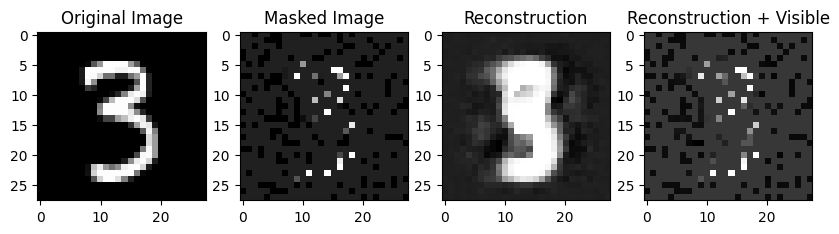

Accuracy: 0.5019
Accuracy: 0.4975
Accuracy: 0.4664
Accuracy: 0.4893
Accuracy: 0.5114
Accuracy: 0.5045
Accuracy: 0.4776
Accuracy: 0.4454
Accuracy: 0.4860
Accuracy: 0.5011
Accuracy: 0.4650
Accuracy: 0.4998
Accuracy: 0.4561
Accuracy: 0.5009
Accuracy: 0.5162
Accuracy: 0.4469
Accuracy: 0.4597
Accuracy: 0.4847
Accuracy: 0.4488
Accuracy: 0.4928
Accuracy: 0.4424
Accuracy: 0.4710
Accuracy: 0.4993
Accuracy: 0.4490
Accuracy: 0.4984
Accuracy: 0.4893
Accuracy: 0.5238
Accuracy: 0.4433
Accuracy: 0.4651
Accuracy: 0.4958
Accuracy: 0.4734
Accuracy: 0.4940
Accuracy: 0.4689
Accuracy: 0.4726
Accuracy: 0.4637
Accuracy: 0.4778
Accuracy: 0.4834
Accuracy: 0.4080
Accuracy: 0.4905
Accuracy: 0.4794
Accuracy: 0.4937
Accuracy: 0.4699
Accuracy: 0.4716
Accuracy: 0.4748
Accuracy: 0.4969
Accuracy: 0.4606
Accuracy: 0.4706
Accuracy: 0.4784
Accuracy: 0.4507
Accuracy: 0.4928
Accuracy: 0.4664
Accuracy: 0.5057
Accuracy: 0.4579
Accuracy: 0.4556
Accuracy: 0.4961
Accuracy: 0.4724
Accuracy: 0.4783
Accuracy: 0.4537
Accuracy: 0.47

In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Define model
class MaskedAutoencoder(nn.Module):
    def __init__(self):
        super(MaskedAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = MaskedAutoencoder()

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train model
for epoch in range(10):
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1)

        # Create a mask with 25% of the pixels visible
        mask = torch.from_numpy(np.random.choice([0, 1], size=img.shape, p=[.75, .25])).float()

        # Apply the mask to the image
        img_masked = img * mask

        img_masked.requires_grad_()
        output = model(img_masked)

        # Calculate loss only for the unmasked pixels
        loss = criterion(output * mask, img * mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, 10, loss.item()))


# Test model
model.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader):
        img, _ = data
        img = img.view(img.size(0), -1)

        # Create a mask with 25% of the pixels visible
        mask = torch.from_numpy(np.random.choice([0, 1], size=img.shape, p=[.75, .25])).float()

        # Apply the mask to the image
        img_masked = img * mask

        # Generate the output
        output = model(img_masked)

        # Calculate the accuracy as 1 - normalized MSE
        accuracy = 1 - criterion(output, img)

        print(f'Accuracy: {accuracy.item():.4f}')

        # Visualize the result on the first image in the batch
        if i == 0:
            img = img[0].view(28, 28)
            img_masked = img_masked[0].view(28, 28)
            output = output[0].view(28, 28)
            composite = output * mask[0].view(28, 28) + img_masked

            plt.figure(figsize=(10, 10))

            plt.subplot(1, 4, 1)
            plt.imshow(img, cmap='gray')
            plt.title('Original Image')

            plt.subplot(1, 4, 2)
            plt.imshow(img_masked, cmap='gray')
            plt.title('Masked Image')

            plt.subplot(1, 4, 3)
            plt.imshow(output, cmap='gray')
            plt.title('Reconstruction')

            plt.subplot(1, 4, 4)
            plt.imshow(composite, cmap='gray')
            plt.title('Reconstruction + Visible')

            plt.show()



Accuracy: 0.6321


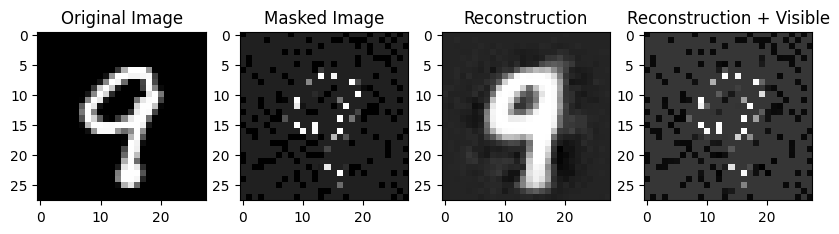

In [5]:
import random
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Pick a random image from the test dataset
random_index = random.randint(0, len(test_dataset) - 1)
img, _ = test_dataset[random_index]

# Reshape and normalize the image
img = img.view(1, -1)

# Create a mask with 25% of the pixels visible
mask = torch.from_numpy(np.random.choice([0, 1], size=img.shape, p=[.75, .25])).float()

# Apply the mask to the image
img_masked = img * mask

# Generate the output from the model
with torch.no_grad():
    output = model(img_masked)

# Calculate the accuracy as 1 - normalized MSE
accuracy = 1 - criterion(output, img)

print(f'Accuracy: {accuracy.item():.4f}')

# Visualize the original image, masked image, reconstruction, and composite
img = img.view(28, 28)
img_masked = img_masked.view(28, 28)
output = output.view(28, 28)
composite = output * mask.view(28, 28) + img_masked

plt.figure(figsize=(10, 10))

plt.subplot(1, 4, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 4, 2)
plt.imshow(img_masked, cmap='gray')
plt.title('Masked Image')

plt.subplot(1, 4, 3)
plt.imshow(output, cmap='gray')
plt.title('Reconstruction')

plt.subplot(1, 4, 4)
plt.imshow(composite, cmap='gray')
plt.title('Reconstruction + Visible')

plt.show()
